In [1]:
!pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [2]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.io import read_image
from PIL import Image
import copy
import time
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
import seaborn as sns
from ptflops import get_model_complexity_info

In [3]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
EPOCHS = 100
model_name = "MobileNetV2"

In [4]:
path = r"/kaggle/working/" + f"result_{model_name}"
if not os.path.exists(path):
    os.mkdir(path)

In [5]:
train_path = r"/kaggle/input/durian-dataset/A Durian Leaf/A Durian Leaf/A_Durian_Leaf_Image_Dataset/Durian_Leaf_Diseases/train"
val_path = r"/kaggle/input/durian-dataset/A Durian Leaf/A Durian Leaf/A_Durian_Leaf_Image_Dataset/Durian_Leaf_Diseases/train"
test_path = r"/kaggle/input/durian-dataset/A Durian Leaf/A Durian Leaf/A_Durian_Leaf_Image_Dataset/Durian_Leaf_Diseases/test"

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

data_transform = {
    "Train": transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    
    "Validation": transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    
    "Test": transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform["Train"])
val_dataset   = datasets.ImageFolder(root=val_path, transform=data_transform["Validation"])
test_dataset  = datasets.ImageFolder(root=test_path, transform=data_transform["Test"])

print("Classes:", train_dataset.classes)

print(f"Số lượng ảnh trong tập train: {len(train_dataset)}")
print(f"Số lượng ảnh trong tập val: {len(val_dataset)}")
print(f"Số lượng ảnh trong tập test: {len(test_dataset)}")

Classes: ['Leaf_Algal', 'Leaf_Blight', 'Leaf_Colletotrichum', 'Leaf_Healthy', 'Leaf_Phomopsis', 'Leaf_Rhizoctonia']
Số lượng ảnh trong tập train: 1814
Số lượng ảnh trong tập val: 1814
Số lượng ảnh trong tập test: 394


In [6]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

data_loader = {"Train": train_loader,
               
              "Validation": val_loader}

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 120MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
def train_model(data_loader, model, criterion, optimizer, num_epochs, device, early_stop=True, patience=10):
    model = model.to(device)
    
    model = torch.nn.DataParallel(model)
    
    since= time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    
    best_val_acc = 0.0
    best_epoch = 0
    wait = 0
    
    history = {'Train_Loss': [], 'Train_Acc': [], 'Validation_Loss': [], 'Validation_Acc': [], 'Time': []}
    
    result_current = {"Train_Loss": None,
                     "Train_Acc": None,
                     "Validation_Loss": None,
                     "Validation_Acc": None}
    
    for epoch in range(num_epochs):
        
        print("-----------------------------------------------------------------------")
        print(f"Epoch {epoch+1}/{num_epochs}")
        epoch_start = time.time()
        
        for phase in ["Train", "Validation"]:
            if phase == "Train":
                model.train()
            else:
                model.eval()

            running_loss, running_correct = 0.0, 0
            total_samples = 0
            
            for images, labels in tqdm(data_loader[phase], desc="Training And Evaluation"):
                images = images.to(device)
                labels = labels.to(device)
                
                with torch.set_grad_enabled(phase=="Train"):
                    outputs = model(images)
                    _, predicts = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "Train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * images.size(0)
                running_correct += torch.sum(predicts == labels).item()
                total_samples += images.size(0)
                
            epoch_loss = running_loss / total_samples
            epoch_acc = running_correct / total_samples

            result_current[f"{phase}_Loss"] = epoch_loss
            result_current[f"{phase}_Acc"] = epoch_acc
            
            history[f"{phase}_Loss"].append(epoch_loss)
            history[f"{phase}_Acc"].append(epoch_acc)

            if phase == "Validation":
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_epoch = epoch
                    wait = 0
                else:
                    wait += 1
                
        epoch_duration = time.time() - epoch_start
        history["Time"].append(epoch_duration)
        print(f"Train Loss: {result_current['Train_Loss']:.4f}, Train Acc: {result_current['Train_Acc']:.4f}")
        print(f"Valid Loss: {result_current['Validation_Loss']:.4f}, Valid Acc: {result_current['Validation_Acc']:.4f}")
        print(f"Epoch {epoch+1} finished in {epoch_duration:.2f}s")

        if early_stop and wait >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement in {patience} epochs).")
            break
    
    print("-----------------------------------------------------------------------")
    time_elapse = time.time() - since
    print(f"Training Complete In {time_elapse}s")
    
    model.load_state_dict(best_model_wts)

    return model, pd.DataFrame(history), time_elapse, best_val_acc, best_epoch

In [10]:
model, history, time_elapse, best_val_acc, best_epoch = train_model(data_loader=data_loader, model=model, 
                                                                    criterion=criterion, optimizer=optimizer, 
                                                                    num_epochs=EPOCHS, device=device, 
                                                                    early_stop=True, patience=10)

-----------------------------------------------------------------------
Epoch 1/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.47it/s]


Train Loss: 0.8421, Train Acc: 0.7343
Valid Loss: 0.2432, Valid Acc: 0.9234
Epoch 1 finished in 47.21s
-----------------------------------------------------------------------
Epoch 2/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.58it/s]


Train Loss: 0.3075, Train Acc: 0.9052
Valid Loss: 0.1452, Valid Acc: 0.9526
Epoch 2 finished in 36.58s
-----------------------------------------------------------------------
Epoch 3/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.53it/s]


Train Loss: 0.2266, Train Acc: 0.9278
Valid Loss: 0.0914, Valid Acc: 0.9719
Epoch 3 finished in 37.00s
-----------------------------------------------------------------------
Epoch 4/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.53it/s]


Train Loss: 0.1833, Train Acc: 0.9410
Valid Loss: 0.1161, Valid Acc: 0.9620
Epoch 4 finished in 36.95s
-----------------------------------------------------------------------
Epoch 5/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.45it/s]


Train Loss: 0.1537, Train Acc: 0.9487
Valid Loss: 0.0678, Valid Acc: 0.9741
Epoch 5 finished in 37.06s
-----------------------------------------------------------------------
Epoch 6/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.36it/s]


Train Loss: 0.1220, Train Acc: 0.9587
Valid Loss: 0.0424, Valid Acc: 0.9884
Epoch 6 finished in 37.40s
-----------------------------------------------------------------------
Epoch 7/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.49it/s]


Train Loss: 0.1139, Train Acc: 0.9664
Valid Loss: 0.0375, Valid Acc: 0.9895
Epoch 7 finished in 36.97s
-----------------------------------------------------------------------
Epoch 8/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.52it/s]


Train Loss: 0.0885, Train Acc: 0.9697
Valid Loss: 0.0239, Valid Acc: 0.9934
Epoch 8 finished in 36.80s
-----------------------------------------------------------------------
Epoch 9/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.60it/s]


Train Loss: 0.0622, Train Acc: 0.9796
Valid Loss: 0.0214, Valid Acc: 0.9934
Epoch 9 finished in 36.56s
-----------------------------------------------------------------------
Epoch 10/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.56it/s]


Train Loss: 0.0866, Train Acc: 0.9708
Valid Loss: 0.0189, Valid Acc: 0.9945
Epoch 10 finished in 36.74s
-----------------------------------------------------------------------
Epoch 11/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.65it/s]


Train Loss: 0.0740, Train Acc: 0.9779
Valid Loss: 0.0186, Valid Acc: 0.9961
Epoch 11 finished in 35.97s
-----------------------------------------------------------------------
Epoch 12/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.60it/s]


Train Loss: 0.0685, Train Acc: 0.9802
Valid Loss: 0.0191, Valid Acc: 0.9961
Epoch 12 finished in 36.03s
-----------------------------------------------------------------------
Epoch 13/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.55it/s]


Train Loss: 0.0741, Train Acc: 0.9735
Valid Loss: 0.0164, Valid Acc: 0.9961
Epoch 13 finished in 36.13s
-----------------------------------------------------------------------
Epoch 14/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.44it/s]


Train Loss: 0.0794, Train Acc: 0.9785
Valid Loss: 0.0141, Valid Acc: 0.9972
Epoch 14 finished in 36.68s
-----------------------------------------------------------------------
Epoch 15/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.60it/s]


Train Loss: 0.0436, Train Acc: 0.9862
Valid Loss: 0.0096, Valid Acc: 0.9972
Epoch 15 finished in 36.10s
-----------------------------------------------------------------------
Epoch 16/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.61it/s]


Train Loss: 0.0395, Train Acc: 0.9879
Valid Loss: 0.0095, Valid Acc: 0.9972
Epoch 16 finished in 36.53s
-----------------------------------------------------------------------
Epoch 17/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.61it/s]


Train Loss: 0.0434, Train Acc: 0.9890
Valid Loss: 0.0068, Valid Acc: 0.9983
Epoch 17 finished in 36.24s
-----------------------------------------------------------------------
Epoch 18/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.55it/s]


Train Loss: 0.0332, Train Acc: 0.9912
Valid Loss: 0.0069, Valid Acc: 0.9989
Epoch 18 finished in 36.30s
-----------------------------------------------------------------------
Epoch 19/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.56it/s]


Train Loss: 0.0232, Train Acc: 0.9945
Valid Loss: 0.0141, Valid Acc: 0.9972
Epoch 19 finished in 36.13s
-----------------------------------------------------------------------
Epoch 20/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.43it/s]


Train Loss: 0.0254, Train Acc: 0.9928
Valid Loss: 0.0053, Valid Acc: 0.9983
Epoch 20 finished in 36.65s
-----------------------------------------------------------------------
Epoch 21/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.56it/s]


Train Loss: 0.0326, Train Acc: 0.9884
Valid Loss: 0.0049, Valid Acc: 0.9989
Epoch 21 finished in 35.87s
-----------------------------------------------------------------------
Epoch 22/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.52it/s]


Train Loss: 0.0311, Train Acc: 0.9901
Valid Loss: 0.0044, Valid Acc: 0.9994
Epoch 22 finished in 36.10s
-----------------------------------------------------------------------
Epoch 23/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.55it/s]


Train Loss: 0.0362, Train Acc: 0.9884
Valid Loss: 0.0142, Valid Acc: 0.9967
Epoch 23 finished in 36.49s
-----------------------------------------------------------------------
Epoch 24/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.62it/s]


Train Loss: 0.0397, Train Acc: 0.9879
Valid Loss: 0.0103, Valid Acc: 0.9983
Epoch 24 finished in 36.20s
-----------------------------------------------------------------------
Epoch 25/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.58it/s]


Train Loss: 0.0385, Train Acc: 0.9884
Valid Loss: 0.0044, Valid Acc: 0.9994
Epoch 25 finished in 36.50s
-----------------------------------------------------------------------
Epoch 26/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.53it/s]


Train Loss: 0.0319, Train Acc: 0.9890
Valid Loss: 0.0056, Valid Acc: 0.9989
Epoch 26 finished in 36.32s
-----------------------------------------------------------------------
Epoch 27/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.60it/s]


Train Loss: 0.0359, Train Acc: 0.9884
Valid Loss: 0.0060, Valid Acc: 0.9994
Epoch 27 finished in 35.92s
-----------------------------------------------------------------------
Epoch 28/100


Training And Evaluation: 100%|██████████| 57/57 [00:16<00:00,  3.51it/s]


Train Loss: 0.0293, Train Acc: 0.9945
Valid Loss: 0.0041, Valid Acc: 0.9994
Epoch 28 finished in 35.98s
-----------------------------------------------------------------------
Epoch 29/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.60it/s]


Train Loss: 0.0252, Train Acc: 0.9912
Valid Loss: 0.0066, Valid Acc: 0.9972
Epoch 29 finished in 35.84s
-----------------------------------------------------------------------
Epoch 30/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.63it/s]


Train Loss: 0.0256, Train Acc: 0.9906
Valid Loss: 0.0071, Valid Acc: 0.9983
Epoch 30 finished in 36.07s
-----------------------------------------------------------------------
Epoch 31/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.59it/s]


Train Loss: 0.0163, Train Acc: 0.9972
Valid Loss: 0.0042, Valid Acc: 0.9983
Epoch 31 finished in 36.01s
-----------------------------------------------------------------------
Epoch 32/100


Training And Evaluation: 100%|██████████| 57/57 [00:15<00:00,  3.69it/s]

Train Loss: 0.0194, Train Acc: 0.9939
Valid Loss: 0.0042, Valid Acc: 0.9989
Epoch 32 finished in 35.99s
Early stopping at epoch 32 (no improvement in 10 epochs).
-----------------------------------------------------------------------
Training Complete In 1175.3647077083588s


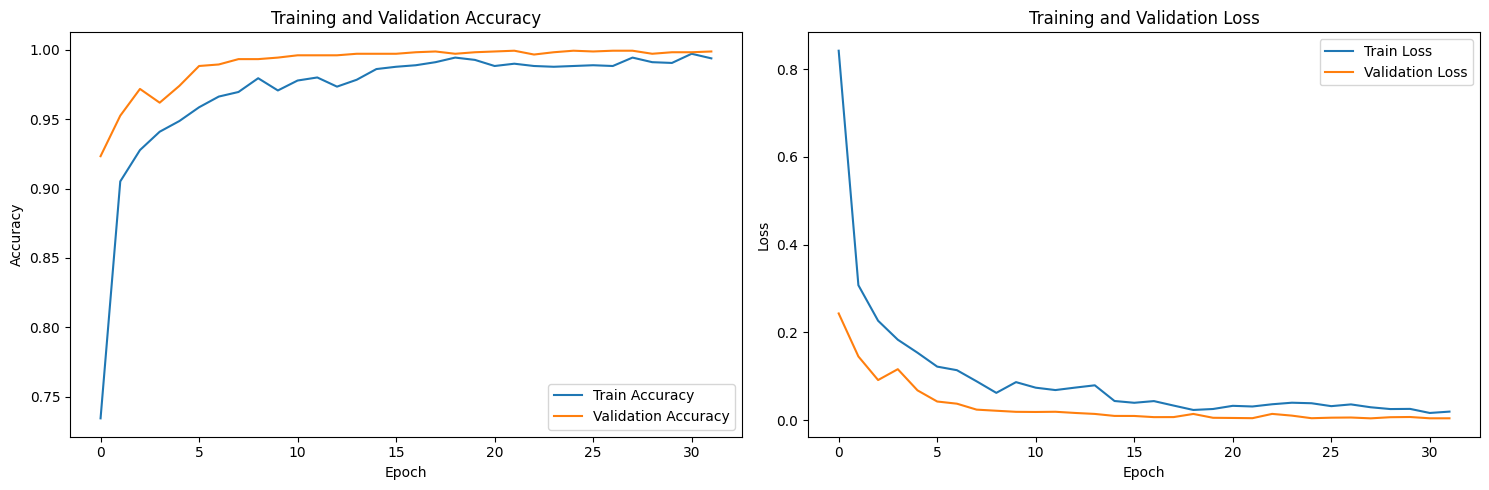

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(history['Train_Acc'], label='Train Accuracy')
axs[0].plot(history['Validation_Acc'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

axs[1].plot(history['Train_Loss'], label='Train Loss')
axs[1].plot(history['Validation_Loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(path, "plot_loss_acc.png"))
plt.show()

Accuracy: 0.9593908629441624
Precision: 0.9593453578061404
Recall: 0.9593908629441624
F1-Score: 0.9589153451181616
                     precision    recall  f1-score   support

         Leaf_Algal     1.0000    1.0000    1.0000        70
        Leaf_Blight     0.9333    0.8485    0.8889        66
Leaf_Colletotrichum     0.9032    0.9333    0.9180        60
       Leaf_Healthy     1.0000    1.0000    1.0000        74
     Leaf_Phomopsis     0.9692    1.0000    0.9844        63
   Leaf_Rhizoctonia     0.9365    0.9672    0.9516        61

           accuracy                         0.9594       394
          macro avg     0.9570    0.9582    0.9572       394
       weighted avg     0.9593    0.9594    0.9589       394



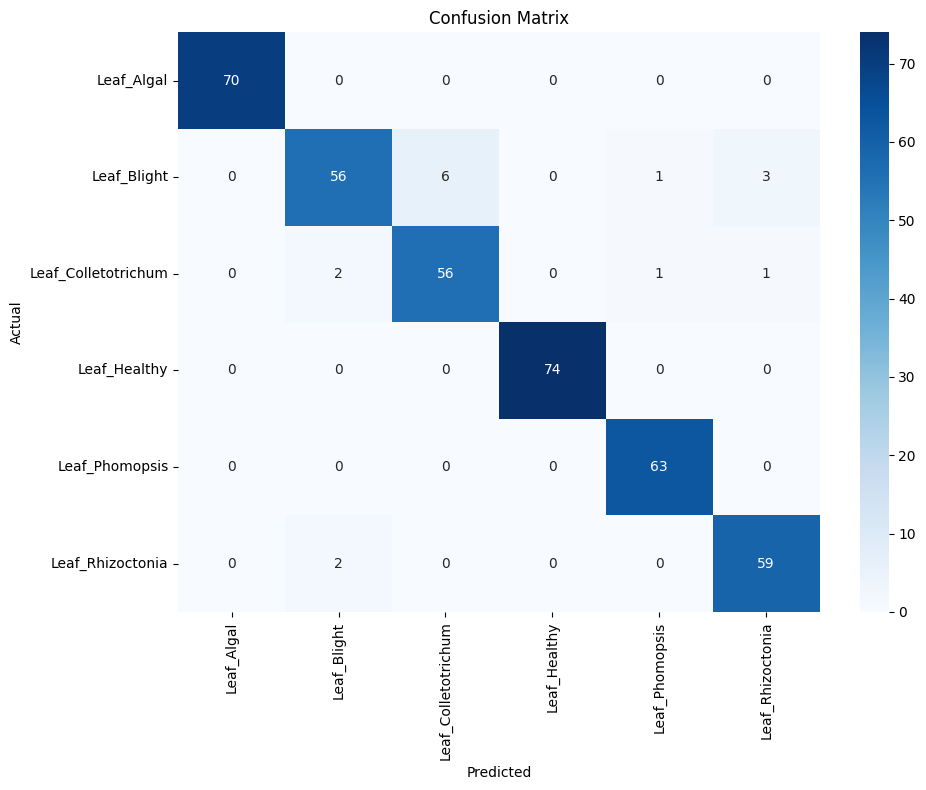

In [12]:
model.eval()

with torch.no_grad():
    
    all_correct = []
    all_predict = []
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicts = torch.max(outputs, dim=1)

        all_correct.extend(labels.cpu().numpy())
        all_predict.extend(predicts.cpu().numpy())

    acc = accuracy_score(all_correct, all_predict)
    precision = precision_score(all_correct, all_predict, average='weighted')
    recall = recall_score(all_correct, all_predict, average='weighted')
    f1 = f1_score(all_correct, all_predict, average='weighted')
    
    input_res = (3, 224, 224)
    flops, params = get_model_complexity_info(model, input_res, as_strings=True, print_per_layer_stat=False)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    result = {
        "Model": model_name,
        "Optimizer": "Adam",
        "Learning_Rate": LEARNING_RATE,
        "Batch_Size": BATCH_SIZE,
        "Num_Epoch": EPOCHS,
        "Early_Stop": best_epoch,
        "Training_Time": time_elapse,
        "Best_Val_Acc": best_val_acc,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "FLOPs": flops,
        "Params": params,
        "Total_Params": total_params,
        "Trainable_Params": trainable_params,
             }
    
    result_df = pd.DataFrame([result])
    result_df.to_csv(os.path.join(path, "result.csv"), index=False)
    
    report = classification_report(all_correct, all_predict, target_names=train_dataset.classes, digits=4)
    print(report)
    with open(os.path.join(path, "classification_report.txt"), "w") as f:
        f.write(report)
        
    cm = confusion_matrix(all_correct, all_predict)
    
    # Hiển thị confusion matrix dưới dạng heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.savefig(os.path.join(path, 'confusion_matrix.png'))
    plt.show()
    
    plt.close()

In [13]:
torch.save(model.state_dict(), os.path.join(path, f'{model_name}_weights.pth'))
history.to_csv(os.path.join(path, "history.csv"), index=False)

In [14]:
import shutil

shutil.make_archive(path, 'zip', path)

'/kaggle/working/result_MobileNetV2.zip'